# Collaboration and Competition

## Introduction

This implementation contains two main Python modules: the game agents, and the neural networks model. The agents contain all the code needed to progress the model training, and can be instantiated with specific hyperparameters. Each agent utilizes a deep deterministic policy gradient via two neural networks. It is deterministic because the "actor" network slowly learns the policy by determing the single best action for any given state. It is a policy gradient because it minimizes loss of the expected vs actual reward for the determined action. Each neural network has three fully connected layers, with activation via ReLU between layers. The agent uses a replay buffer and the model injects noise to facilitate exploration of the action space. By encapsulating all the prcedural code within the agent object, multiple agents (with differing hyperparameters) can be compared. This agent was adapted from my continuous control project solution and creates multiple agents to play each other while learning. It was found that the less coupling each agent had to the other, the better each agent would converge on a solution.

The neural network uses linear layers (i.e., y = Wx + b, where the weight W represents regional slopes for learned features). Each linear layer is connected via the ReLU activation function, which allows for strong gradient flow during back propagation (i.e, the derivative is 1 for positive values), and "kills" weights for unimportant features (i.e., negative weights are zeroed). Backpropagation is via the PyTorch Adam optimizer with the learning rate settable on agent instantiation. For all cases in this project, a learning rate of 0.001 was used for the optimizer. This was emperically observed to be a better rate than some of the smaller learning rates used in other projects. It is suspected that this is the case due to the sparser nature of the states space (i.e., hitting the ball initially is rare, and a lot of learning needs to happen to account for the less likely event).

Other hyperparameters that are settable for each agent include:

1. The discount rate $\gamma$, which determines how much the next state is valued for each action. For this project, the discount rate was set to 0.99 for all training agents.
2. The learning frequency, which controls how frequently the agent enters the learning cycle from the exploration cycle. For this project, the learning frequency was set to 4 for all training agents. This means that the learning cycle runs every 4 experiences within each episode. The Agent class is implemented such that this is also the target networks' update freqeuncies.
3. The soft update factor $\tau$, which controls how much to value the learning update coming from the local networks. High values causes the target networks to more closely mirror the local function and can over train the model, causing longer training runs to reach convergence or potentially never reaching convergence at all. For small values, learning may be too slow, which also slows down convergence to a solution. For this project, $\tau$ was set to 0.07 for all training runs. This relatively high value was chosen from empirical evidence again accounting for the spareser rewards when training starts.
4. The initial exploration width $\sigma$. Because the netwokrs are deterministic, there is not native exploration with this algorithm. To introduce exploration, Gaussian noise was added to each action and clipped between the action bounds [-1, 1]. The starting width of this normal noise distribution is set centered with the distribution mean. As the agent learns, the noise decays.
5. The noise decay rate factor is the percentage of the distribution width to carry into the next experience. For example, if this factor is 0.995, then the width step $d\sigma/dt$ is -0.005.
6. The minimum noise width, which allows some exploration to always exist.
7. The actor and critic network layer size can also be set with a default of 128. Each network is identical with the exception of their outputs. Each actor's network outputs 2 actions (forward/backward and jump) between [-1, 1] (via the $tanh()$ function), while the critic outputs a single, unbounded scaler for the expected reward for the determined action in the given state.

Each actor's network was also initialized with limited weights based on the Xavier (Glorot) initialization, which make a more timid initial actor.

In addition to the above, the agent object employs an SQLite connection to a database to store each actor's training results (i.e., the average episode score for each episode). This allows for later recall and comparison as needed (see below). The agent also prints the actors' progress in real time as it trains. This progress includes the average episode score and the percent change in the neural networks norm for each actor. Specifically, the initial norm (which can be thought of as the model tensor's "length" or magnitude) is taken before each episode and after and the percent change is calculate. This gives the programmer an idea of how fast the target is learning. Large changes mean the model is learning fast (perhaps too quickly) and very small changes means it is not learning very fast (or perhpas not at all).

Results from the training are shown and discussed below.

In [1]:
from ast import literal_eval

from multi_agent import DB_CUR
import matplotlib.pyplot as plt

/home/student/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 34: CUDA driver is a stub library (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
INFO:matplotlib.font_manager:generated new fontManager


In [2]:
data = DB_CUR.execute("SELECT * FROM training_results").fetchall()

In [3]:
for row in data:
    print(row[0:-2])

('player_0_1739057790', 0.99, 0.07, 0.001, 4, 1.0, 0.001, 0.9999, 1000000, 128, 128)
('player_1_1739057790', 0.99, 0.07, 0.001, 4, 1.0, 0.001, 0.9999, 1000000, 128, 128)
('player_0_1739068030', 0.99, 0.07, 0.001, 4, 1.0, 0.001, 0.9999, 1000000, 128, 128)
('player_1_1739068030', 0.99, 0.07, 0.001, 4, 1.0, 0.001, 0.9999, 1000000, 128, 128)
('player_0_1739077120', 0.99, 0.07, 0.001, 4, 0.5, 0.001, 0.995, 1000000, 128, 128)
('player_1_1739077120', 0.99, 0.07, 0.001, 4, 0.5, 0.001, 0.995, 1000000, 128, 128)


## Discussion

This was the hardest project in this nano-degree and it took many training attempts to find a solution. I first started by using the same network for both actors. Each actor took turns on the same network using their respective state observation. It was found that the actors would fight each other and the network would not train. I then tried two seperate actors and one shared critic. However, again, it appeared the actors would fight each other (if one was learning the other got worse and vice versa). I then setup the architecture so that each actor had its own actor and critic network. This worked better, but again only one actor would learn. Because only one actor would learn, the other could not provide any good feedback and so the learning actor would only learn so much. This architecture is shown in the plot below as timestamp id 1729057790. Finally, further decoupling the actors by giving each their own random sampling out of the replay buffer every learning loop provide exponential learning and convergence. I then tried to narrow exploration, thinking the actors were over exploring (see final timestamp id in plot). However, reducing exploration actually slowed convergence. In the cases where I finally observed convergence on a solution, each actor's actor and critic networks only tooke that actor's experiences as inputs (i.e., it own states and action, the critic did not look at the other actor's state). I found that this decoupling was necessary to allow each agent to learn on its own, providing a skilled oponent to the other agent, allowing further learning.

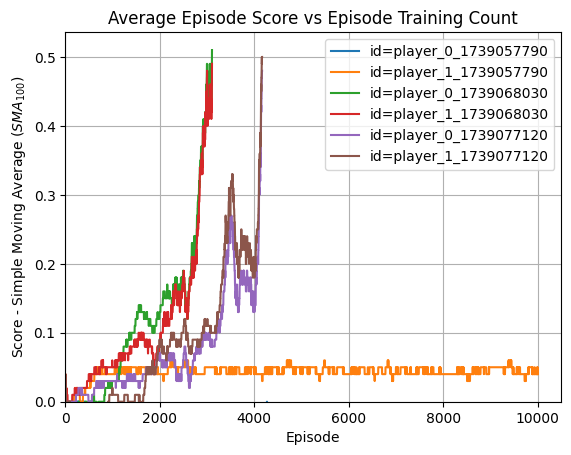

In [4]:
for training_run in data:
    moving_average = literal_eval(training_run[-1])
    plt.plot([_ for _ in range(1, len(moving_average) + 1)], moving_average, label=f"id={training_run[0]}")
plt.title("Average Episode Score vs Episode Training Count")
plt.xlim(0,)
plt.ylim(0,)
plt.xlabel("Episode")
plt.ylabel("Score - Simple Moving Average ($SMA_{100}$)")
plt.grid()
plt.legend()
plt.show()